## An example Python data analysis notebook

This page illustrates how to use Python to perform a simple but complete analysis: retrieve data, do some computations based on it, and visualise the results.

**Don't worry if you don't understand everything on this page!** Its purpose is to give you an example of things you can do and how to go about doing them - you are not expected to be able to reproduce an analysis like this in Python at this stage! We will be looking at the concepts and practices introduced on this page as we go along the course.

As we show the code for different parts of the work, we will be touching on various aspects you may want to keep in mind, either related to Python specifically, or to research programming more generally.

### Why write software to manage your data and plots? 

We can use programs for our entire research pipeline. Not just big scientific simulation codes, but also the small scripts which we use to tidy up data and produce plots. This should be code, so that the whole research pipeline
is recorded for reproducibility. Data manipulation in spreadsheets is much harder to share or 
check. 

You can see another similar demonstration on the [software carpentry site](https://swcarpentry.github.io/python-novice-inflammation/02-numpy/index.html). 
We'll try to give links to other sources of Python training along the way.
Part of our approach is that we assume you know how to use the internet! If you
find something confusing out there, please bring it along to the next session. In this course, we'll always try to draw your attention to other sources of information about what we're learning. Paying attention to as many of these as you need to, is just as important as these core notes.

### Importing Libraries

Research programming is all about using libraries: tools other people have provided programs that do many cool things.
By combining them we can feel really powerful but doing minimum work ourselves. The python syntax to import someone else's library is "import".

In [1]:
import geopy # A python library for investigating geographic information.
# https://pypi.org/project/geopy/

Now, if you try to follow along on this example in an Jupyter notebook, you'll probably find that 
you just got an error message.

You'll need to wait until we've covered installation of additional python libraries later in the course, then come
back to this and try again. For now, just follow along and try get the feel for how programming for data-focused
research works.

In [2]:
# Select geocoding service provided by OpenStreetMap's Nominatim - https://wiki.openstreetmap.org/wiki/Nominatim
geocoder = geopy.geocoders.Nominatim(user_agent="comp0023") 
geocoder.geocode('Cambridge', exactly_one=False)

[Location(Cambridge, Cambridgeshire, Cambridgeshire and Peterborough, England, United Kingdom, (52.2055314, 0.1186637, 0.0)),
 Location(Cambridge, Middlesex County, Massachusetts, United States, (42.3750997, -71.1056157, 0.0)),
 Location(Cambridge, Region of Waterloo, Southwestern Ontario, Ontario, Canada, (43.3600536, -80.3123023, 0.0)),
 Location(Cambridge, Henry County, Illinois, United States, (41.3025257, -90.1962861, 0.0)),
 Location(Cambridge, Isanti County, Minnesota, 55008, United States, (45.5727408, -93.2243921, 0.0)),
 Location(Cambridge, Story County, Iowa, 50046, United States, (41.8990768, -93.5294029, 0.0)),
 Location(Cambridge, Dorchester County, Maryland, 21613, United States, (38.5714624, -76.0763177, 0.0)),
 Location(Cambridge, Guernsey County, Ohio, 43725, United States, (40.031183, -81.5884561, 0.0)),
 Location(Cambridge, Jefferson County, Kentucky, United States, (38.2217369, -85.616627, 0.0)),
 Location(Cambridge, Cowley County, Kansas, United States, (37.316988

The results come out as a **list** inside a list: `[Name, [Latitude, Longitude]]`. 
Programs represent data in a variety of different **containers** like this.

### Comments

Code after a `#` symbol doesn't get run.

In [3]:
print("This runs") # print("This doesn't")
# print("This doesn't either")

This runs


### Functions

We can wrap code up in a **function**, so that we can repeatedly get just the information we want.


In [4]:
def geolocate(city):
    """Get the latitude and longitude of a specific location."""
    
    full_name, coordinates = geocoder.geocode(city)
    return coordinates


Defining **functions** which put together code to make a more complex task seem simple from the outside is the most important thing in programming. The output of the function is specified using the `return` keyword. The input to the function is put inside brackets after the function name:


In [5]:
geolocate(city='Cambridge')

(52.2055314, 0.1186637)

### Variables

We can store a result in a variable:

In [6]:
london_location = geolocate("London")
print(london_location)

(51.5073359, -0.12765)


### More complex functions

We'll fetch a map of a place from the Google Maps server, given a longitude and latitude.
The URLs look like: `https://mt0.google.com/vt?x=658&y=340&z=10&lyrs=s`. Since we'll frequently be generating these URLs, we will create two helper functions to make our life easier.

The first is a function to convert our latitude and longitude into the coordinate system used by Google Maps. If interested, you can see [more details of the mathematics](https://wiki.openstreetmap.org/wiki/Slippy_map_tilenames#X_and_Y).
We will then create a second function to build up a web request from the URL given our parameters.


In [7]:
import os
import math
import requests

def deg2num(lat_deg, lon_deg, zoom):
    """Convert latitude and longitude to XY format."""

    lat_rad = math.radians(lat_deg)
    n = 2.0 ** zoom
    x_coord = int((lon_deg + 180.0) / 360.0 * n)
    y_coord = int((1.0 - math.asinh(math.tan(lat_rad)) / math.pi) / 2.0 * n)

    return (x_coord, y_coord)

def request_map_at(latitude, longitude, zoom=10, satellite=True):
    """Retrieve a map from Google at a given location."""

    base_url = "https://mt0.google.com/vt?"
    x_coord, y_coord = deg2num(latitude, longitude, zoom)

    params = dict(
        x=x_coord,
        y=y_coord,
        z=zoom,
    )
    if satellite:
        params['lyrs'] = 's'
    
    return requests.get(base_url, params=params)


In [8]:
london_latitude, london_longitude = london_location
map_response = request_map_at(london_latitude, london_longitude)


### Checking our work

Let's see what URL we ended up with.

Firsty we will define two constants so that we can split the returned URL into the base URL and the part of the URL that corresponds to the location we requested:


In [9]:
BASE_URL = slice(0, 25)
LOCATION_REQUESTED = slice(25, None)


In [10]:
url = map_response.url

print(url)
print(url[BASE_URL])
print(url[LOCATION_REQUESTED])


https://mt0.google.com/vt?x=511&y=340&z=10&lyrs=s
https://mt0.google.com/vt
?x=511&y=340&z=10&lyrs=s


`url` is a string and we can select parts of this string using the `slice`s we defined above. `BASE_URL` will select characters 0 to 24 of the string and `LOCATION_REQUESTED` will select all characters from the 25th onwards.


We can write **tests** so that if we change our code later we can check the results are still valid. We will do this here using `assert` statements. If any of those `assert` statements are `False` we will get an error. If we receive an error from our tests we know we need to fix something in our code.

In [11]:
assert "https://mt0.google.com/vt?" in url
assert "z=10" in url
assert "lyrs=s" in url


Our previous function comes back with an Object representing the web request. In Python, we can use the `.
operator` to get access to a particular **attribute** of the object. In this case, the image at the requested URL is stored in the `content` attribute. It's a big file, so let's just get look at first few bytes:


In [12]:
map_response.content[0:20]


b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00'

### Displaying results

We'll need to do this a lot, so we can wrap up our previous function in another function to save on typing.

In [13]:
def map_content_at(latitude, longitude, zoom=10, satellite=True):
    """Retrieve a map image from Google at a given location."""

    return request_map_at(latitude, longitude, zoom=10, satellite=True).content


We can use a library that comes with Jupyter notebook to display the image. This is one of the most powerful things about modern programming languages like Python - being able to work with images, documents, or any other kind of data just as easily as we can with numbers or strings.


In [14]:
import IPython

map_png = map_content_at(london_latitude, london_longitude)


In [15]:
print("The type of our map result is actually a: ", type(map_png))


The type of our map result is actually a:  <class 'bytes'>


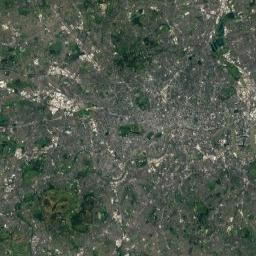

In [16]:
IPython.core.display.Image(map_png)

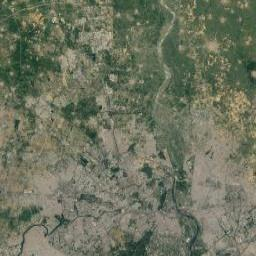

In [17]:
IPython.core.display.Image(map_content_at(*geolocate("New Delhi")))

### Manipulating Numbers

Now we get to our research project: we want to use satellite imagery to find out how urbanised the world is along a line between two cites. We expect the satellite image to be greener in the countryside.


We'll need to import a few more libraries to count how much green there is in an image.


In [18]:
from io import BytesIO  # A library to convert between files and strings
import numpy as np  # A library to deal with matrices
import imageio  # A library to deal with images


Let's define what we count as green:

In [19]:
def is_green(pixels):
    """Determine if each pixel in an image array is green."""
    
    # RGB indices
    RED = 0
    GREEN = 1
    BLUE = 2
    
    threshold = 1.1
    greener_than_red = pixels[:, :, GREEN] > threshold * pixels[:, :, RED]
    greener_than_blue = pixels[:, :, GREEN] > threshold * pixels[:, :, BLUE]
    green = np.logical_and(greener_than_red, greener_than_blue) 

    return green


This code has assumed we have our pixel data for the image as a $256 \times 256 \times 3$ 3-d matrix,
with each of the three layers being red, green, and blue pixels.

We find out which pixels are green by comparing, element-by-element, the middle (green, number 1) layer to the top (red, zero) and bottom (blue, 2)

Now we just need to parse in our data, which is a PNG image, and turn it into our matrix format:

In [20]:
def count_green_in_png(data):
    """Determine the total number of green pixels in an image."""

    f = BytesIO(data)
    pixels = imageio.imread(f) # Get our PNG image as a numpy array

    return np.sum(is_green(pixels))


In [21]:
london_map = map_content_at(london_latitude, london_longitude)
green_count_london = count_green_in_png(london_map)
print(green_count_london)


31418


/var/folders/sj/t15lvqd955z0scwp13cyt1180000gn/T/ipykernel_7905/897312775.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  pixels = imageio.imread(f) # Get our PNG image as a numpy array


In [22]:
imageio.imread(BytesIO(london_map)).shape


/var/folders/sj/t15lvqd955z0scwp13cyt1180000gn/T/ipykernel_7905/437983355.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  imageio.imread(BytesIO(london_map)).shape


(256, 256, 3)

We'll also need a function to get an evenly spaced set of places between two endpoints:

In [23]:
def location_sequence(start, end, steps):
    """Generate a sequence of evenly spaced locations between a two sets of coordinates."""

    start_latitude, start_longitude = start
    end_latitude, end_longitude = end
    
    latitudes = np.linspace(start_latitude, end_latitude, steps) # generate linearly spaced data
    longitudes = np.linspace(start_longitude, end_longitude, steps)

    path = np.vstack([latitudes, longitudes]).transpose()
    
    return path


In [24]:
london_to_cambridge = location_sequence(
    start=geolocate("London"),
    end=geolocate("Cambridge"),
    steps=5,
)


### Creating Images

We should display the green content to check our work:

In [25]:
def show_green_in_png(data):
    """Convert all non-green pixels in an RGB image to black.

    Red and blue channel are set to 0 for all pixels.
    Pixels that are green will have the green channel set to 1.
    Pixels that are non-green will have the green channel set to 0.
    """
    
    f = BytesIO(data)
    pixels = imageio.imread(f) # Get our PNG image as a numpy array
    green_pixels = is_green(pixels)

    GREEN_CHANNEL = 1
    binary_pixels = np.zeros_like(pixels, dtype=np.int8)
    binary_pixels[green_pixels, GREEN_CHANNEL] = 1
    
    buffer = BytesIO()
    binary_image = imageio.imwrite(buffer, binary_pixels, format='png')

    return buffer.getvalue()


In [26]:
london_location

(51.5073359, -0.12765)

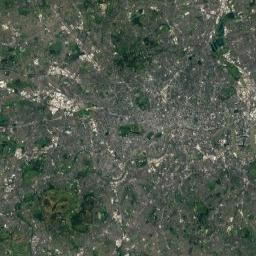

In [27]:
IPython.core.display.Image(
    map_content_at(london_latitude, london_longitude, satellite=True)
)

/var/folders/sj/t15lvqd955z0scwp13cyt1180000gn/T/ipykernel_7905/379957995.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  pixels = imageio.imread(f) # Get our PNG image as a numpy array
Lossy conversion from int8 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


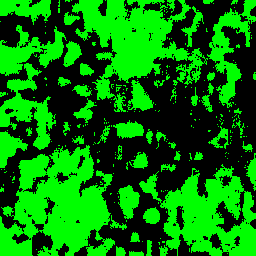

In [28]:
IPython.core.display.Image(
    show_green_in_png(
        map_content_at(
            london_latitude,
            london_longitude,
            satellite=True,
        )
    )
)


### Looping

We can loop over each element in out list of coordinates and get a map for that place:

/var/folders/sj/t15lvqd955z0scwp13cyt1180000gn/T/ipykernel_7905/1599168453.py:14: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  IPython.core.display.display(


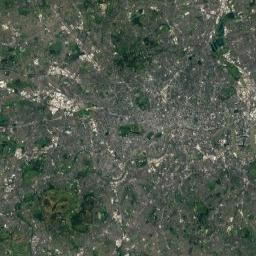

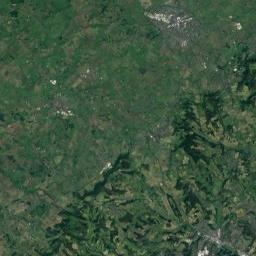

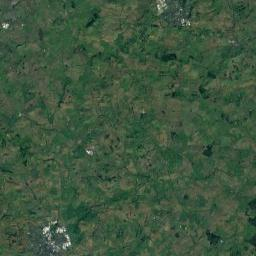

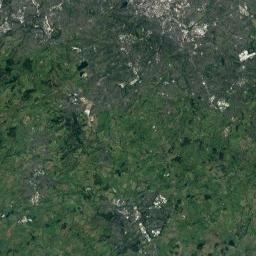

In [29]:
london_to_birmingham = location_sequence(
    start=geolocate("London"),
    end=geolocate("Birmingham"),
    steps=4,
)

london_to_birmingham_maps = []

for latitude, longitude in london_to_birmingham:

    current_map = map_content_at(latitude, longitude)
    london_to_birmingham_maps.append(current_map)
    
    IPython.core.display.display( 
        IPython.core.display.Image(
            current_map,
        )
    )


So now we can count the green from London to Birmingham!

In [30]:
green_at_each_location = [count_green_in_png(current_map) for current_map in london_to_birmingham_maps]
print(green_at_each_location)


[31418, 63370, 63371, 60063]


/var/folders/sj/t15lvqd955z0scwp13cyt1180000gn/T/ipykernel_7905/897312775.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  pixels = imageio.imread(f) # Get our PNG image as a numpy array


### Plotting graphs

Let's plot a graph.

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline

Text(0, 0.5, '$N_{green}$')

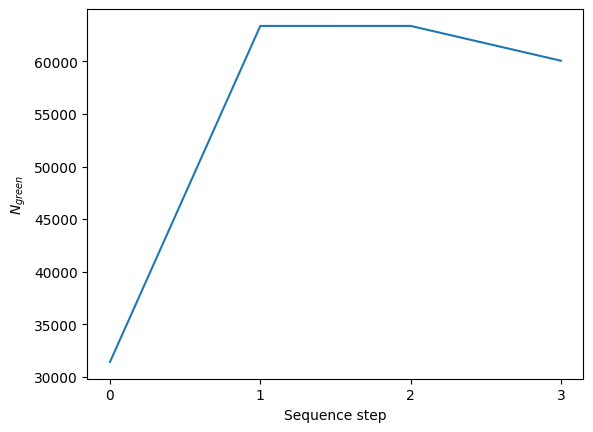

In [32]:
plt.plot(green_at_each_location)

plt.xticks([0, 1, 2, 3])
plt.xlabel("Sequence step")
plt.ylabel(r"$N_{green}$")


From a research perspective, of course, this code needs a lot of work. But I hope the power of using programming is clear.


### Composing Program Elements

We built little pieces of useful code, to:

* Find latitude and longitude of a place
* Get a map at a given latitude and longitude
* Decide whether a (red,green,blue) triple is mainly green
* Decide whether each pixel is mainly green
* Plot a new image showing the green places
* Find evenly spaced points between two places

By putting these together, we can make a function which can plot this graph automatically for any two places:

In [33]:
def green_between(start, end, steps):
    """Count the amount of green space along a linear path between two locations."""

    sequence = location_sequence(
        start=geolocate(start),
        end=geolocate(end),
        steps=steps,
    )
    maps = [map_content_at(latitude, longitude) for latitude, longitude in sequence]
    green_at_each_location = [count_green_in_png(current_map) for current_map in maps]
    
    return green_at_each_location


/var/folders/sj/t15lvqd955z0scwp13cyt1180000gn/T/ipykernel_7905/897312775.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  pixels = imageio.imread(f) # Get our PNG image as a numpy array


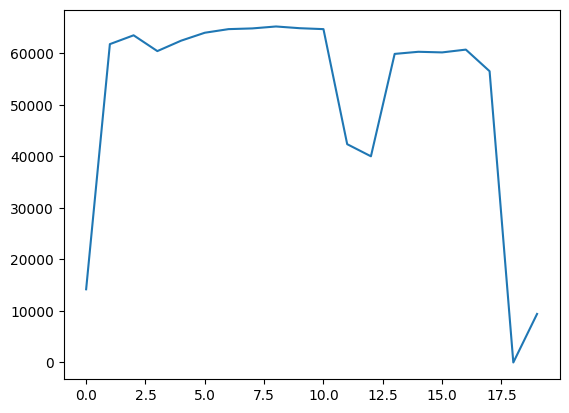

In [34]:
plt.plot(green_between('New York', 'Chicago', 20))


/var/folders/sj/t15lvqd955z0scwp13cyt1180000gn/T/ipykernel_7905/897312775.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  pixels = imageio.imread(f) # Get our PNG image as a numpy array


Text(0, 0.5, '$N_{green}$')

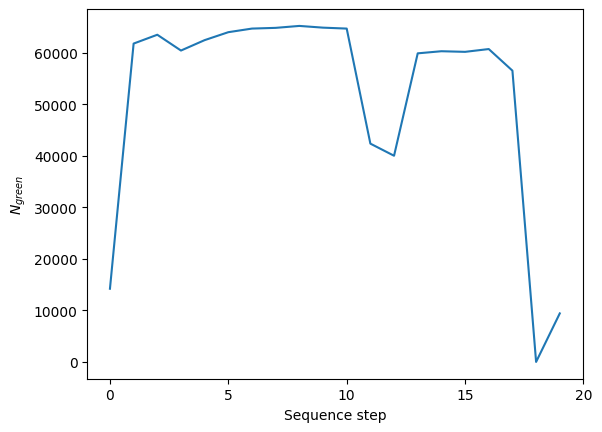

In [35]:
plt.plot(green_between('New York', 'Chicago', 20))

plt.xticks(np.arange(0, 21, 5))
plt.xlabel("Sequence step")
plt.ylabel(r"$N_{green}$")


And that's it! We've covered, very very quickly, the majority of the python language, and much of the theory of software engineering.

Now we'll go back, carefully, through all the concepts we touched on, and learn how to use them properly ourselves.